In [0]:
import math
import time
import imageio
import numpy as np

In [0]:
from sklearn import preprocessing
from sklearn.datasets import make_moons

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [0]:
# Training settings
class Args:
    train_size=1500
    test_size=1500
    batch_size=1
    test_batch_size=1500
    lr=0.01
    momentum=0.0
    no_cuda=False
    epochs=100
    log_interval=300
    rows = 4
    cols = 4
    seed=0
    save_checkpoints=False
    load_checkpoint=None #'mnist_012.pth'

args = Args
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Generate Two Moons Dataset
Chapter 18 of Glassner's book describes his datset as follows (note the normalization that occurs):

![image.png](attachment:image.png)

### Define the Dataset class

In [0]:
class TwoMoonsDataset(Dataset):
    """Two Moons dataset."""

    def __init__(self, noise=0.08, n_samples=1500):
        """
        Args:
            noise (float): Amount of noise to use.
            n_samples (int): Number of samples to generate.
        """
        np.random.seed(42)
        (moons_xy, moons_labels) = make_moons(n_samples=n_samples, noise=noise)
        self.sample = preprocessing.scale(moons_xy.astype(float))
        self.target = moons_labels

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (self.sample[idx], np.reshape(self.target[idx],(1)))

### Create the training set and test set loaders
Here we test on the same data we train with--the random seed is the same in the class and we have the same noise and number of points.

In [0]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=args.train_size, noise=0.08), batch_size=args.batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=args.test_size, noise=0.08), batch_size=args.test_batch_size, **kwargs)

### Plot the two datasets to make sure they look right

In [0]:
def plot_moons(dataset, title):
    clr_list = ['#8800FF', '#FF0000']
    clrs = [clr_list[v] for v in dataset.target]

    plt.scatter(dataset.sample[:,0], dataset.sample[:,1], c=clrs, s=15, linewidths=0.5, edgecolors='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.tight_layout()
    plt.axis('equal')
    plt.xticks()
    plt.yticks()

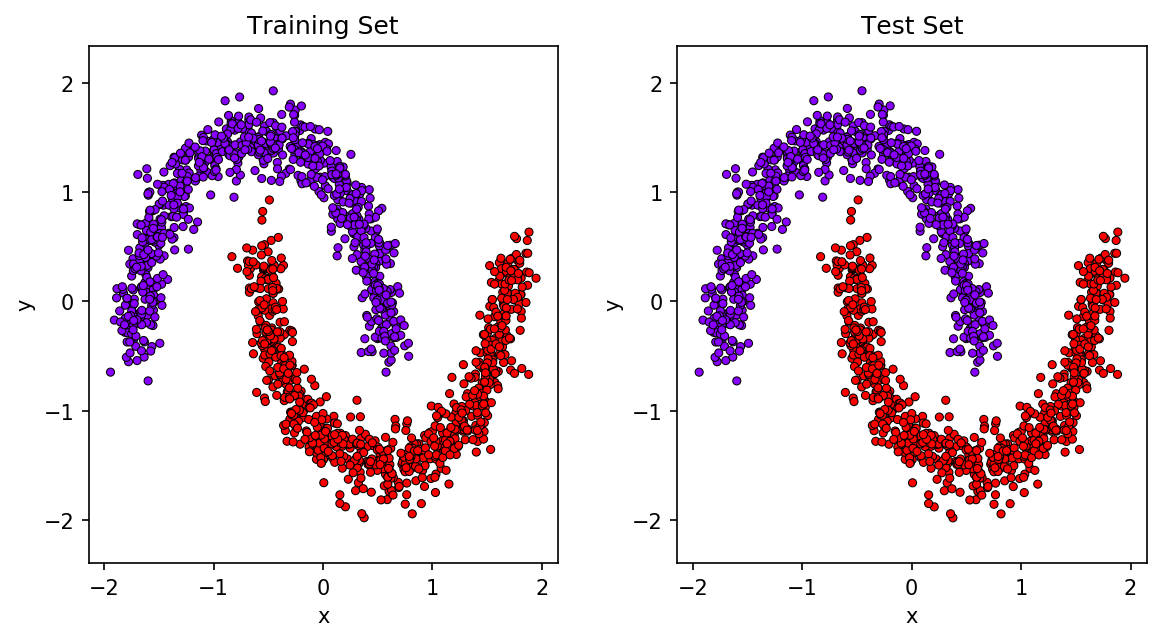

In [9]:
plt.figure(figsize=(8,12), dpi=150)
plt.subplot(3, 2, 1)
plot_moons(train_loader.dataset, 'Training Set')

plt.subplot(3, 2, 2)
plot_moons(test_loader.dataset, 'Test Set')

# Define the Two-Layer Network
As noted below, Andrew Glassner includes a bias term in each activation and the network has a total of 37 parameters

![image.png](attachment:image.png)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 4, bias=True)
        self.fc3 = nn.Linear(4, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

### Instantiate the network

In [0]:
#torch.manual_seed(args.seed)
#device = torch.device("cpu")
#model = Net().float().to(device)

### Print Network Dimensions and Weights
We show 37 parameters below, which matches Glassners

In [0]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:\n")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))
        print('{}\n'.format(model.state_dict()[param_tensor]))
        
    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [0]:
#print_model_size(model)

### Visualize Cost Landscape
scikit has an example that plots decision surfaces
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [0]:
def plot_decision_surface(dataset, model, seed, zoom=1.0, epoch_id=None):
    # Get samples
    samples = dataset.sample;
    X = torch.tensor(samples).float()
    X = X.to(device)
    
    # Count number correct
    Z = model(X)
    pred = torch.round(Z).long() # Round to 0/1
    x = torch.tensor(dataset.target)
    x = x.to(device)
    correct = pred.eq(x.view_as(pred)).sum().item()
    total = len(pred)
    
    # Get meshgrid for surface
    h = 0.02 * zoom   
    x_min, x_max = samples[:, 0].min() - .5, samples[:, 0].max() + .5
    y_min, y_max = samples[:, 1].min() - .5, samples[:, 1].max() + .5
    
    scale = (zoom-1)/2.0
    x_delta = scale * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
    y_delta = scale * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Classify each point on the grid
    X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    X_grid = X_grid.to(device)
    
    Z_grid = model(X_grid).detach().cpu().numpy()
    
    fig = plt.figure(figsize=(4,4), dpi=64)
    
    # Plot decision surface
    canvas = FigureCanvas(fig)
    if epoch_id is None:
        plt.title('Decision Surface\n{} Out of {} Correct'.format(correct, total), loc='left')
    else:
        plt.title('Seed {: >#5} - Epoch {: >#6.2f}\n{}/{} Correct'.format(seed, epoch_id, correct, total))        
    plt.tight_layout()
    
    Z_grid = Z_grid.reshape(xx.shape)
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, Z_grid, norm=mpl.colors.Normalize(vmin=0.,vmax=1.), cmap=cm, alpha=.8)

    # Plot samples
    X = dataset.sample
    y_train=dataset.target
    cm_bright = ListedColormap(['#FF0000', '#8800FF'])
    plt.scatter(X[:, 0], X[:, 1], s=15, linewidths=0.5, c=y_train, norm=mpl.colors.Normalize(vmin=0.,vmax=1.), cmap=cm_bright, edgecolors='k')
    
    # Convert figure canvas to an image
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    image = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    
    plt.close(fig)
    
    return(image)

# Train the Network

In [0]:
def train(args, model, device, train_loader, optimizer, loss_criterion, epoch, log_fn):
    # Set model to be in training mode
    model.train()
    sample_idx = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = loss_criterion(output, target.float())
        loss.backward()
        optimizer.step()
        
        sample_idx += len(data)
        if (batch_idx+1) % args.log_interval == 0:
            if log_fn is not None:
                log_fn(epoch, sample_idx, len(data), loss.item(), train_loader, model)

In [0]:
def test(args, model, device, loss_criterion, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            test_loss += loss_criterion(output, target.float()).item() # sum up batch loss
            pred = torch.round(output).long() # Round to 0/1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, loss_criterion, epoch, log_fn, verbose=False):
    if verbose is True:
        train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, loss_criterion, epoch, log_fn)
    
    if verbose is True:
        train_end = time.perf_counter()
        train_delta = train_end - train_start
        print("Training took {:.1f}s.\n".format(train_delta))

        test_start = time.perf_counter()
        test(args, model, device, test_loader)
        test_end = time.perf_counter()
        test_delta = test_end - test_start

        print("Testing took {:.1f}s.\n".format(test_delta))   

### Code to Plot Decision Surfaces
The functor is the callback that gets passed into the train function. It runs every ```args.log_interval``` samples. This lets us plot the decision surface periodically during training.

In [0]:
class mini_batch_functor:
    def __init__(self, seed, verbose=False, filename=None): 
        self.images = []
        self.verbose = verbose
        self.filename = filename
        self.seed = seed
    
    def __call__(self, epoch, sample_idx, batch_size, loss, data_loader, model):
        sample_total = len(data_loader.dataset)
        if self.verbose is True:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, sample_idx, sample_total,
                100. * sample_idx / sample_total, loss/batch_size))
        
        epoch_id = np.round(epoch - 1 + sample_idx/sample_total,2)
        img = plot_decision_surface(data_loader.dataset, model, self.seed, epoch_id=epoch_id)
        if self.filename is not None:
            imageio.imsave(self.filename.format(epoch_id), img)

In [0]:
def create_decision_boundary_gif(train_loader, test_loader, filename=None, verbose=True, seed=0):
    torch.manual_seed(seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().float().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    loss_criterion = nn.MSELoss()

    print('seeding[{}][{}] = {}'.format(row, col, seed))

    callback=mini_batch_functor(seed, verbose=verbose, filename=filename)

    if verbose is True:
        print("Initialized:")
        test(args, model, device, test_loader)
        print("")

    callback(1, 0, 1, 0, train_loader, model)    
    for epoch in range(1, args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, loss_criterion, epoch, callback, verbose=verbose)

### Multiple Initializations
This code runs a set of rows x cols initializations and saves out pngs for the decision surface every ```args.log_interval``` samples through the training data.

Once that finishes, they are read in, concatenated into a tiled image and then saved out as an animated gif of the decision surface as the optimzation progresses. 

In [20]:
rand_max = 10000
np.random.seed(args.seed)
rand_offset = np.random.randint(rand_max)
np.random.seed(args.seed)

for row in range(args.rows):
    for col in range(args.cols):
        fn = 'two_moons_optimization_{}_{}_'.format(row,col) + '{:0>#6.2f}.png'
        seed = np.random.randint(rand_max)-rand_offset
        create_decision_boundary_gif(train_loader, test_loader, filename=fn, verbose=False, seed=seed)

seeding[0][0] = 0
seeding[0][1] = 7113
seeding[0][2] = 532
seeding[0][3] = 2127
seeding[1][0] = 6493
seeding[1][1] = 5159
seeding[1][2] = 1641
seeding[1][3] = 3142
seeding[2][0] = 4012
seeding[2][1] = 736
seeding[2][2] = -2027
seeding[2][3] = -133
seeding[3][0] = -510
seeding[3][1] = 5036
seeding[3][2] = 165
seeding[3][3] = 7161


### Create Animation

In [21]:
sample_total = args.train_size
minibatch_count = np.ceil(sample_total / args.log_interval).astype(int)
with imageio.get_writer('two_moons_{}x{}.gif'.format(args.rows, args.cols), mode='I') as writer:
    for epoch in range(0, args.epochs):
        print('processing epoch {}/{}'.format(epoch+1, args.epochs))

        if epoch is args.epochs-1:
            minibatch_count += 1
        for minibatch in range(minibatch_count):
            sample_idx = np.min((sample_total, args.log_interval*minibatch))
            epoch_id = np.round(epoch + sample_idx/sample_total,2)

            images = []
            for row in range(args.rows):
                img_row = []
                for col in range(args.cols):
                    fn = 'two_moons_optimization_{}_{}_{:0>#6.2f}.png'.format(row,col,epoch_id)
                    img_row.append(imageio.imread(fn))
                images.append(img_row)
            tiled_image = np.vstack(list(map(lambda row: np.hstack(row), images)))
            writer.append_data(tiled_image)


processing epoch 1/100
processing epoch 2/100
processing epoch 3/100
processing epoch 4/100
processing epoch 5/100
processing epoch 6/100
processing epoch 7/100
processing epoch 8/100
processing epoch 9/100
processing epoch 10/100
processing epoch 11/100
processing epoch 12/100
processing epoch 13/100
processing epoch 14/100
processing epoch 15/100
processing epoch 16/100
processing epoch 17/100
processing epoch 18/100
processing epoch 19/100
processing epoch 20/100
processing epoch 21/100
processing epoch 22/100
processing epoch 23/100
processing epoch 24/100
processing epoch 25/100
processing epoch 26/100
processing epoch 27/100
processing epoch 28/100
processing epoch 29/100
processing epoch 30/100
processing epoch 31/100
processing epoch 32/100
processing epoch 33/100
processing epoch 34/100
processing epoch 35/100
processing epoch 36/100
processing epoch 37/100
processing epoch 38/100
processing epoch 39/100
processing epoch 40/100
processing epoch 41/100
processing epoch 42/100
p